# Step 1 – Data Pre-processing and management:

## Generate a spectrogram from a file
Do imports first

In [300]:
#import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
# to enable zooming in matplotlib in notebook
#%matplotlib notebook
#conda install -c conda-forge ipympl # or pip install ipympl #This is to allow zooming in the notebook
#matplotlib ipympl
import tensorflow as tf     #pip install tensorflow
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Call Type : RUPE B

Name audio and annotation file that you want to import (without the extensions), then read in the audio and annotations

In [301]:
#File index
file =  '5713.210809120002'  #from PPT at time 892-896 (Rupe B)
#file = 'Rupes A and B\\5713.210809120002'  #from PPT at time 892-896 (Rupe B)
#file = 'Guttural rupe\\5711.211013040024'
#file = 'Rupes A and B\\5713.210825190002'
#file =          'Moan\\5713.210902110002'  #from PPT at time 212 seconds

#Read the 2 files
sample_rate, samples = wavfile.read(file+'.wav')
annot_file_path = file +'.Table.1.selections.txt'

#Read the file into a DataFrame
df = pd.read_csv(file +'.Table.1.selections.txt', sep='\t')

#Display the first few rows of the DataFrame
#print(df.head())
print(df)

    Selection           View  Channel  Begin Time (s)  End Time (s)  \
0           1  Spectrogram 1        1      871.984579    872.045877   
1           2  Spectrogram 1        1      872.605082    872.730809   
2           3  Spectrogram 1        1      873.525329    873.616653   
3           4  Spectrogram 1        1      874.776471    874.904325   
4           5  Spectrogram 1        1      876.693356    876.876005   
5           6  Spectrogram 1        1      877.095183    877.364589   
6           7  Spectrogram 1        1      884.521098    884.664983   
7           8  Spectrogram 1        1      887.606950    887.981380   
8           9  Spectrogram 1        1      891.800005    892.179001   
9          10  Spectrogram 1        1      892.539731    893.119640   
10         11  Spectrogram 1        1      893.553430    893.927859   
11         12  Spectrogram 1        1      894.343384    894.576261   
12         13  Spectrogram 1        1      895.302288    895.768042   
13    

### Calculate the Spectrogram

In [302]:
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nperseg=2456, nfft=4096, noverlap=1228, window='hann')       #Try nfft=8192 if computer permits

In [303]:
fmax = max(df['High Freq (Hz)'])
fmax

682.927

In [304]:
fmin = min(df['Low Freq (Hz)'])
fmin

42.314

In [305]:
time = df['End Time (s)'] - df['Begin Time (s)']
max_time = max(time)
max_time

0.5799086759999454

With the resultsing spectrogram, trim all the tiny values so that log scale displays correctly. Also, all of the relevant info is below 1KHz so trim the data to only display sub 1-KHz frequencies

In [306]:
spectrogram[spectrogram < 0.001] = 0.001    #Trim off all the tiny values so that log scale displays correctly

#Trim in frequency
#fmin = 20 # Hz
#fmax = 1000 # Hz
freq_slice = np.where((frequencies >= fmin) & (frequencies <= fmax))

#keep only frequencies of interest
frequencies = frequencies[freq_slice]
spectrogram = spectrogram[freq_slice,:][0]

Next I'm going to define a function that will overlay the annotated rectangles onto the spectrogram (different colours for each call)

In [307]:
def overlay_annotations(ax, df, annotation_colors):
    #Track labels to ensure they are added only once in the legend
    added_labels = set()

    for _, row in df.iterrows():
        start_time = row['Begin Time (s)']
        end_time = row['End Time (s)']
        low_freq = row['Low Freq (Hz)']
        high_freq = row['High Freq (Hz)']
        annotation = row['Annotation']

        #Skip if the annotation is not in the defined colors
        if annotation not in annotation_colors:
            continue

        #Draw rectangles
        ax.add_patch(
            plt.Rectangle(
                (start_time, low_freq),  #Bottom Left corner
                end_time - start_time,  #Width (time)
                high_freq - low_freq,  #Height (frequency)
                edgecolor=annotation_colors[annotation],
                facecolor='none',
                linewidth=2,
                label=annotation if annotation not in added_labels else None  #Add label once
            )
        )
        added_labels.add(annotation)  #Mark label as added

    ax.legend(loc='upper right')     #Add legend

I've also written a function below that updates the colormap when you zoom in on a particular region - so that the max and min values are always visible

In [308]:
def update_colormap(event):
    #Get current view limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    #Find indices corresponding to the current view limits
    x_indices = np.where((times >= xlim[0]) & (times <= xlim[1]))[0]
    y_indices = np.where((frequencies >= ylim[0]) & (frequencies <= ylim[1]))[0]

    #Handle cases where no data is visible
    if len(x_indices) == 0 or len(y_indices) == 0:
        return

    #Extract the visible data
    data_visible = spectrogram[np.ix_(y_indices, x_indices)]
    #data_visible = np.log(spectrogram)[np.ix_(y_indices, x_indices)]

    #Compute new color limits
    vmin = np.nanmin(data_visible)
    vmax = np.nanmax(data_visible)

    #Update the color limits of the pcolormesh
    pc.set_clim(vmin=vmin, vmax=vmax)

    #Update the colorbar to reflect the new color limits
    cbar.update_normal(pc)

    #Redraw the figure
    plt.draw()


Ok, let's plot the spectrogram and annotations

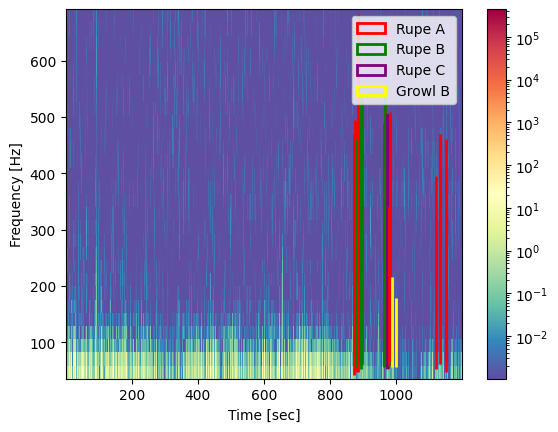

In [309]:
#Define colors for annotations
annotation_colors = {
    "Rupe A": "red",
    "Rupe B": "green",
    "Growl B": "yellow",
    "Rupe C" : "purple",
    "Moan": "pink",
    "G rupe" : "blue"
}

pc = plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
#pc = plt.pcolormesh(times, frequencies, np.log(spectrogram))
cbar = plt.colorbar(pc)
#plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

#Get the current axes
ax = plt.gca()
overlay_annotations(ax, df, annotation_colors)

#Connect the update function to the axes limit change events
ax.callbacks.connect('xlim_changed', update_colormap)
ax.callbacks.connect('ylim_changed', update_colormap)

plt.show()

Note : As you can see in the spectogram above for file 5713.210809120002, there are no calls between 400 seconds and 800 seconds.

Extract out a portion of interest from the spectrogram when you can hear a RUPE B call

(24, 469)


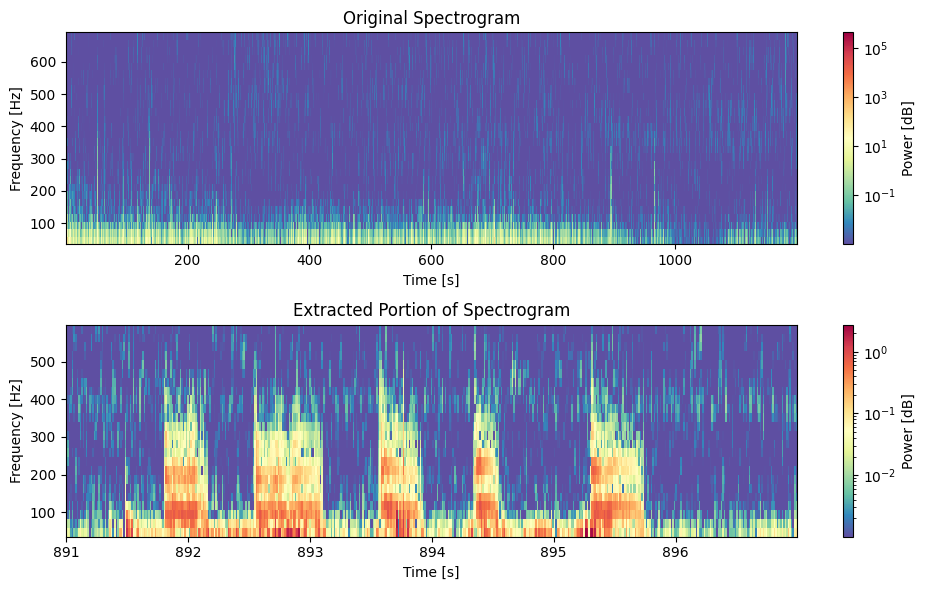

In [310]:
#Define time and frequency limits
time_start, time_end = 891, 897  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
#time_indices = np.where((times >= time_start) & (times <= time_end))[0]

#Find indices for the time range
# The original condition resulted in an empty array
# time_indices = np.where((times >= time_start) & (times <= time_end))[0]
# Let's find the closest time indices to the desired range
time_indices = np.where(np.logical_and(times >= time_start, times <= time_end))[0]
# If the above results in an empty array, find the nearest indices:
if len(time_indices) == 0:
    #time_indices = np.where(np.abs(times - (time_start + time_end) / 2) < (time_end - time_start) / 2)[0]
    closest_time_index = np.argmin(np.abs(times - (time_start + time_end) / 2))
    time_indices = np.array([closest_time_index])  # Create an array with the closest index
#Find indices for the frequency range
#freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]


#Extract the portion of the spectrogram
spectrogram_sub = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print(spectrogram_sub.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()


In [311]:
spectrogram_sub
#print(spectrogram_sub.shape)

array([[0.01508444, 0.03358499, 0.02289664, ..., 0.00242916, 0.08366761,
        0.10191491],
       [0.0133384 , 0.01381747, 0.01443471, ..., 0.001     , 0.0445008 ,
        0.03014504],
       [0.00867754, 0.00160618, 0.00556618, ..., 0.001     , 0.012999  ,
        0.00917109],
       ...,
       [0.00108675, 0.001     , 0.001     , ..., 0.00116472, 0.001     ,
        0.001     ],
       [0.001     , 0.001     , 0.001     , ..., 0.001     , 0.001     ,
        0.001     ],
       [0.001     , 0.001     , 0.001     , ..., 0.001     , 0.001     ,
        0.001     ]], dtype=float32)

I'm going to extract a single call now and check the size of the spectrogram array

In [312]:
time_end = time_start + max_time
print(time_end)

891.579908676


In [313]:
df['Spectogram'] = None
#print(df.head())

In [314]:
for index, row in df.iterrows():
    start_time = row['Begin Time (s)']
    end_time = row['End Time (s)']
    low_freq = row['Low Freq (Hz)']
    high_freq = row['High Freq (Hz)']
    annotation = row['Annotation']
    time_indices = np.where((times >= time_start) & (times <= time_end))[0]

    #Find indices for the frequency range
    freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

    #Extract the portion of the spectrogram
    spectrogram_sub = spectrogram[freq_indices][:, time_indices]
    frequencies_sub = frequencies[freq_indices]
    times_sub = times[time_indices]
    print(spectrogram_sub.shape)
    df['Spectogram'][index] = spectrogram_sub



(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)
(24, 46)


<ipython-input-314-c5bdfbb1d542>:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Spectogram'][index] = spectrogram_sub
<ipython-input-314-c5bdfbb1d542>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [315]:
df.Spectogram[1]

array([[0.01508444, 0.03358499, 0.02289664, ..., 0.0609968 , 0.06421833,
        0.21231116],
       [0.0133384 , 0.01381747, 0.01443471, ..., 0.01292771, 0.03185356,
        0.0678402 ],
       [0.00867754, 0.00160618, 0.00556618, ..., 0.01226219, 0.01000667,
        0.00301265],
       ...,
       [0.00108675, 0.001     , 0.001     , ..., 0.00222304, 0.001     ,
        0.001     ],
       [0.001     , 0.001     , 0.001     , ..., 0.00199188, 0.001     ,
        0.001     ],
       [0.001     , 0.001     , 0.001     , ..., 0.00177285, 0.001     ,
        0.001     ]], dtype=float32)

In [316]:
df.head

<bound method NDFrame.head of     Selection           View  Channel  Begin Time (s)  End Time (s)  \
0           1  Spectrogram 1        1      871.984579    872.045877   
1           2  Spectrogram 1        1      872.605082    872.730809   
2           3  Spectrogram 1        1      873.525329    873.616653   
3           4  Spectrogram 1        1      874.776471    874.904325   
4           5  Spectrogram 1        1      876.693356    876.876005   
5           6  Spectrogram 1        1      877.095183    877.364589   
6           7  Spectrogram 1        1      884.521098    884.664983   
7           8  Spectrogram 1        1      887.606950    887.981380   
8           9  Spectrogram 1        1      891.800005    892.179001   
9          10  Spectrogram 1        1      892.539731    893.119640   
10         11  Spectrogram 1        1      893.553430    893.927859   
11         12  Spectrogram 1        1      894.343384    894.576261   
12         13  Spectrogram 1        1      895.302288    895.768042   
13         14  Spectrogram 1        1      962.736346    963.151872   
14         15  Spectrogram 1        1      963.498904    963.845936   
15         16  Spectrogram 1        1      964.453241    964.613059   
16         17  Spectrogram 1        1      965.754611    966.051415   
17         18  Spectrogram 1        1      972.047129    972.576810   
18         19  Spectrogram 1        1      973.209271    973.775818   
19         20  Spectrogram 1        1      979.219406    979.370091   
20         21  Spectrogram 1        1      979.767351    980.109817   
21         22  Spectrogram 1        1      981.799315    982.013926   
22         23  Spectrogram 1        1      986.811774    987.176303   
23         24  Spectrogram 1        1      998.455312    998.801535   
24         25  Spectrogram 1        1     1120.870469   1120.943528   
25         26  Spectrogram 1        1     1131.585286   1131.792121   
26         27  Spectrogram 1        1     1150.020158   1150.093217   
27         28  Spectrogram 1        1     1150.321528   1150.412852   
28         29  Spectrogram 1        1      884.961746    885.231530   

    Low Freq (Hz)  High Freq (Hz)  Delta Time (s)  Delta Freq (Hz)  \
0          75.224         426.862          0.0613          351.638   
1          42.314         470.151          0.1257          427.837   
2          65.821         493.658          0.0913          427.837   
3          70.523         441.942          0.1279          371.419   
4          47.015         413.733          0.1826          366.718   
5          56.418         460.748          0.2694          404.330   
6          47.009         422.764          0.1439          375.755   
7          65.821         441.942          0.3744          376.121   
8          61.120         451.345          0.3790          390.225   
9          61.120         474.852          0.5799          413.732   
10         51.717         535.972          0.3744          484.255   
11         61.120         526.569          0.2329          465.449   
12         61.120         531.270          0.4658          470.150   
13         56.418         488.957          0.4155          432.539   
14         61.120         460.748          0.3470          399.628   
15         61.120         521.867          0.1598          460.747   
16         56.418         535.972          0.2968          479.554   
17         51.717         460.748          0.5297          409.031   
18         56.418         503.061          0.5665          446.643   
19         61.120         338.509          0.1507          277.389   
20         61.120         413.733          0.3425          352.613   
21         65.821         508.547          0.2146          442.726   
22         56.418         216.269          0.3645          159.851   
23         56.418         178.657          0.3462          122.239   
24         51.717         394.927          0.0731          343.210   
25         61.120  

Spectrogram size:  (24, 55)


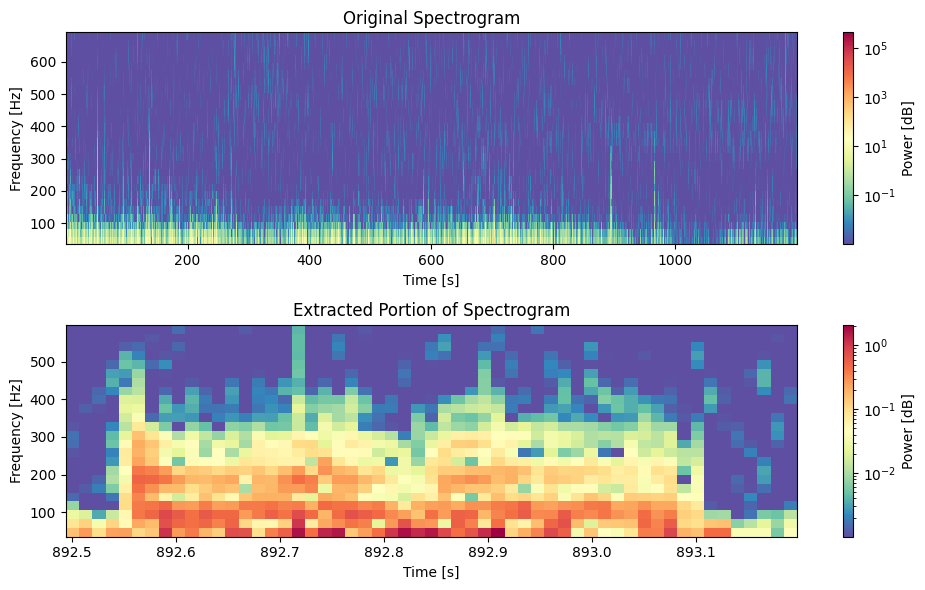

In [317]:
#Define time and frequency limits
time_start, time_end = 892.5, 893.2  # Time range in seconds
#time_start, time_end = 892.5, time_end  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
#time_indices = np.where((times >= time_start) & (times <= time_end))[0]
# Let's find the closest time indices to the desired range
time_indices = np.where(np.logical_and(times >= time_start, times <= time_end))[0]
# If the above results in an empty array, find the nearest indices:
if len(time_indices) == 0:
    closest_time_index = np.argmin(np.abs(times - time_start)) #Changed time_start to be the desired start time for plotting
    time_indices = np.array([closest_time_index])  # Create an array with the closest index

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub_rupe_b = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print("Spectrogram size: ", spectrogram_sub_rupe_b.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub_rupe_b, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()

Try and save the spectrogram plot. (I wouldn't actually do this in practice - I would save the extracted spectrogram as raw data to be used for ML)

In [318]:
plt.savefig('spectrogram_rupe_b.png')
#plt.clf()
print(spectrogram_sub_rupe_b)
print(spectrogram_sub.shape)

[[0.16026706 0.26273516 0.09804009 ... 0.03795517 0.00569286 0.04049847]
 [0.08340926 0.12152962 0.03355524 ... 0.02268031 0.00826415 0.03017188]
 [0.02604808 0.01921352 0.00339473 ... 0.00584165 0.00499745 0.01219802]
 ...
 [0.001      0.001      0.001      ... 0.001      0.001      0.001     ]
 [0.001      0.001      0.001      ... 0.001      0.00109778 0.001     ]
 [0.001      0.001      0.001      ... 0.001      0.001      0.001     ]]
(24, 46)


<Figure size 640x480 with 0 Axes>

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
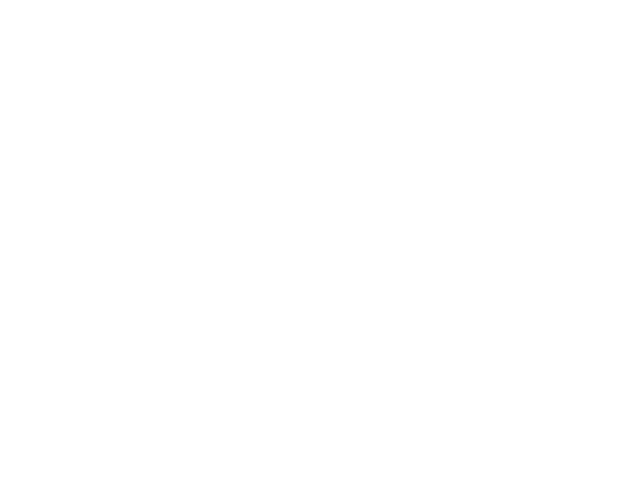

In [319]:
from PIL import Image
import numpy as np
image = Image.open('spectrogram_rupe_b.png').convert('L')
image_array_rupe_b = np.array(image)
image_array_rupe_b

## Call Type : No Call

As you can see in the spectogram above for file 5713.210809120002, there are no calls between 875.0 seconds and 876.5 seconds.
Lets do a spectogram of a no call between 400.5 seconds and 401.2 seconds

(24, 118)


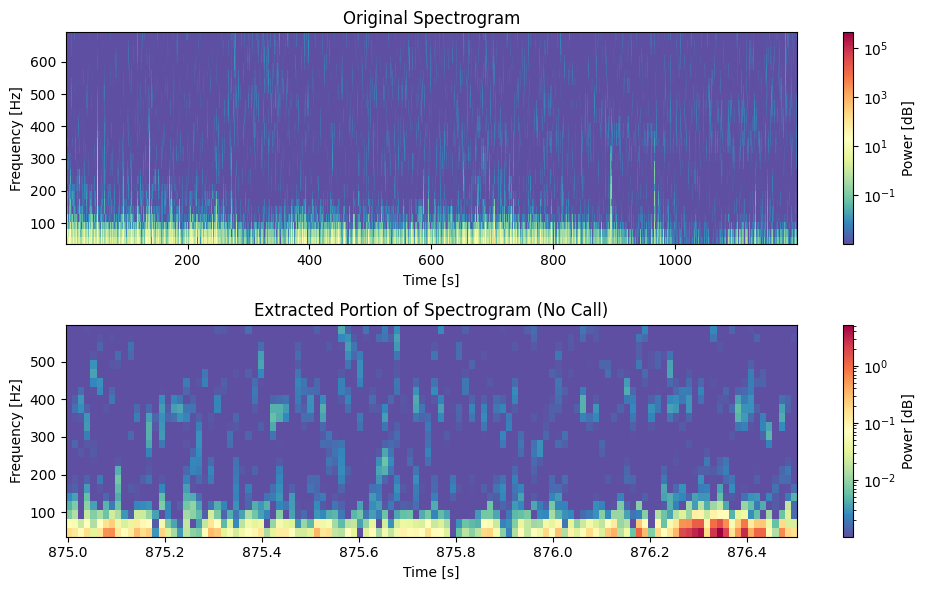

In [320]:
#Define time and frequency limits
time_start, time_end = 875.0, 876.5  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
#time_indices = np.where((times >= time_start) & (times <= time_end))[0]
# Let's find the closest time indices to the desired range
time_indices = np.where(np.logical_and(times >= time_start, times <= time_end))[0]
# If the above results in an empty array, find the nearest indices:
if len(time_indices) == 0:
    closest_time_index = np.argmin(np.abs(times - time_start)) #Changed time_start to be the desired start time for plotting
    time_indices = np.array([closest_time_index])  # Create an array with the closest index

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub_no_call = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print(spectrogram_sub_no_call.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub_no_call, norm=LogNorm(), cmap='Spectral_r') #spectrogram_sub was not being updated with the values corresponding to "no call". spectrogram_sub_no_call contains this data. Update spectrogram_sub
plt.title('Extracted Portion of Spectrogram (No Call)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()

In [321]:
plt.savefig('spectrogram_no_call.png')
#plt.clf()
print(spectrogram_sub_no_call)
print(spectrogram_sub.shape)

[[0.17224267 0.13497664 0.07974511 ... 0.64070815 0.1940373  0.15730757]
 [0.06169079 0.05614277 0.02095202 ... 0.18052486 0.0252554  0.02545362]
 [0.0075847  0.01416101 0.001      ... 0.0060515  0.02758963 0.00156178]
 ...
 [0.001      0.001      0.001      ... 0.001      0.001      0.001     ]
 [0.001      0.001      0.001      ... 0.001      0.001      0.00113395]
 [0.001      0.001      0.001      ... 0.001      0.001      0.001     ]]
(24, 46)


<Figure size 640x480 with 0 Axes>

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
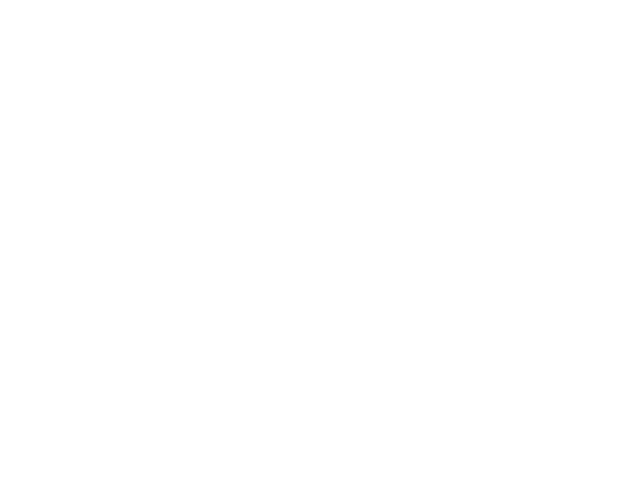

In [322]:
from PIL import Image
import numpy as np
image = Image.open('spectrogram_no_call.png').convert('L')
image_array_no_call = np.array(image)
image_array_no_call

In [323]:
nocall_rupeb = zip(image_array_no_call, image_array_rupe_b)
df_nocall_rupeb = pd.DataFrame(nocall_rupeb, columns=('image_array_no_call', 'image_array_rupe_b'))
df_nocall_rupeb.image_array_no_call

,image_array_no_call
0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
1,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
2,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
3,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
4,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
...,...
475,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
476,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
477,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
478,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."


In [324]:
df_nocall_rupeb.head()

,image_array_no_call,image_array_rupe_b
0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
1,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
2,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
3,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
4,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."


### TRAIN TEST SPLIT

In [325]:
#X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1138)

In [326]:
X = spectrogram_sub
#y = df.Annotation[0:25]
y = df.Annotation[0:24]
#y = df.Annotation[0]
# Instead of selecting the first element of 'Annotation', use a label for the single sample
#y = np.array([df.Annotation[0]])  # Assuming you want to use the first annotation as the label
#Reshape X before train_test_split to add a sample dimension
#X = X.reshape(-1, spectrogram_sub.shape[0], spectrogram_sub.shape[1])  # Reshape to (samples, 25, 55)

# Reshape X to have the correct number of samples
# Assuming you have 25 samples, each with 25x55 features
# If the number of samples is different, adjust the first dimension accordingly
#X = X.reshape(1, spectrogram_sub.shape[0], spectrogram_sub.shape[1])

#Now proceed with the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1138)

print(y)
numberofclasses = np.unique(y).size
print("numberofclasses: ", numberofclasses)

0      Rupe A
1      Rupe A
2      Rupe A
3      Rupe A
4      Rupe A
5      Rupe B
6      Rupe A
7      Rupe B
8      Rupe B
9      Rupe B
10     Rupe B
11     Rupe B
12     Rupe B
13     Rupe B
14     Rupe B
15     Rupe A
16     Rupe B
17     Rupe B
18     Rupe C
19     Rupe A
20     Rupe B
21     Rupe A
22    Growl B
23    Growl B
Name: Annotation, dtype: object
numberofclasses:  4


### SEQUENTIAL TENSOR FLOW KERAS MODEL

In [327]:
model = tf.keras.models.Sequential()
#model.add(tf.keras.layers.Flatten(input_shape=(25, 0)))
model.add(tf.keras.layers.Dense(100,activation='relu'))
model.add(tf.keras.layers.Dense(100,activation='relu'))
model.add(tf.keras.layers.Dense(100,activation='relu'))
model.add(tf.keras.layers.Dense(numberofclasses))

In [328]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### COMPILE MODEL

In [329]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [330]:
# Get all unique labels from both y_train and y_test
# Convert y_test to a NumPy array to avoid potential issues with Pandas Series
y_test_array = y_test.to_numpy()

# Get all unique labels from both y_train and y_test
#all_labels = np.unique(np.concatenate((y_train, y_test_array)))

#Instead of using np.concatenate, get unique labels separately and then combine them
unique_train_labels = np.unique(y_train) # Get unique numerical labels from y_train
unique_test_labels = np.unique(y_test_array) # Get unique string labels from y_test_array

# Combine the unique labels
all_labels = np.union1d(unique_train_labels, unique_test_labels) # Use union1d to combine unique values from both arrays

# Fit the LabelEncoder on all unique labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

#label_encoder = LabelEncoder()
y_train = label_encoder.transform(y_train)
#y_test = label_encoder.transform(y_test)

# Transform y_test using the fitted LabelEncoder
y_test = label_encoder.transform(y_test_array)

### FIT MODEL

In [331]:
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1429 - loss: 1.3977 - val_accuracy: 0.5000 - val_loss: 1.3832
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5714 - loss: 1.3806 - val_accuracy: 0.5000 - val_loss: 1.3802
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7857 - loss: 1.3637 - val_accuracy: 0.5000 - val_loss: 1.3769
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7857 - loss: 1.3476 - val_accuracy: 0.5000 - val_loss: 1.3736
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7857 - loss: 1.3324 - val_accuracy: 0.5000 - val_loss: 1.3701
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8571 - loss: 1.3166 - val_accuracy: 0.2500 - val_loss: 1.3663
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8571 - loss: 1.3004 - val_accuracy: 0.2500 - val_loss: 1.3623
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8571 - loss: 1.2836 - val_accuracy: 0.2500 - val_loss: 1.3580
Ep

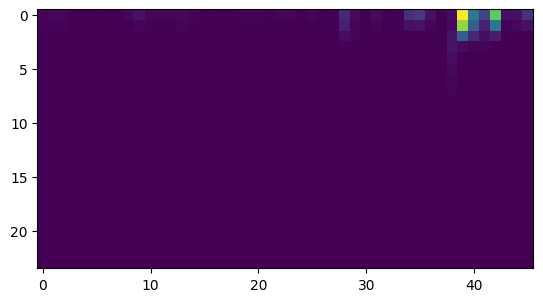

In [332]:
plt.imshow(spectrogram_sub)

In [333]:
X_test

array([[0.00161467, 0.001     , 0.001     , 0.00107836, 0.001     ,
        0.001     , 0.00342823, 0.001     , 0.001     , 0.001     ,
        0.001     , 0.0024808 , 0.00164994, 0.001     , 0.00109062,
        0.00205489, 0.00314175, 0.00141581, 0.0024381 , 0.001     ,
        0.001     , 0.00360477, 0.00174009, 0.001     , 0.001     ,
        0.00242734, 0.001     , 0.001     , 0.00164313, 0.001     ,
        0.001     , 0.001     , 0.0017991 , 0.001     , 0.00129045,
        0.00133852, 0.001     , 0.001     , 0.02915709, 0.00597404,
        0.00122783, 0.00154883, 0.001     , 0.001     , 0.00188639,
        0.00213098],
       [0.001     , 0.001     , 0.001     , 0.001     , 0.00285465,
        0.001     , 0.001     , 0.00125655, 0.001     , 0.001     ,
        0.00118803, 0.001     , 0.001     , 0.001     , 0.001     ,
        0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
        0.001     , 0.001     , 0.00300942, 0.001     , 0.001     ,
        0.001     , 0.001  

In [334]:
y_pred = model.predict(X_test)
#y_pred[6].max()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


In [335]:
y_test

array([1, 3, 2, 2, 0, 2])

### MODEL ACCURACY

In [336]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)

1/1 - 0s - 37ms/step - accuracy: 0.1667 - loss: 1.3750


In [337]:
print("Model accuracy = ", accuracy)

Model accuracy =  0.1666666716337204


### Training and Validation Loss

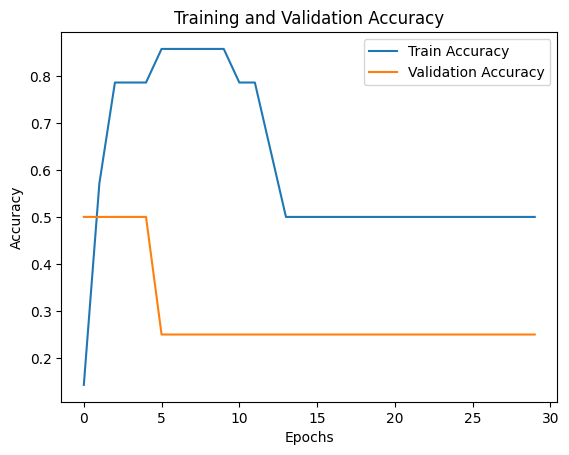

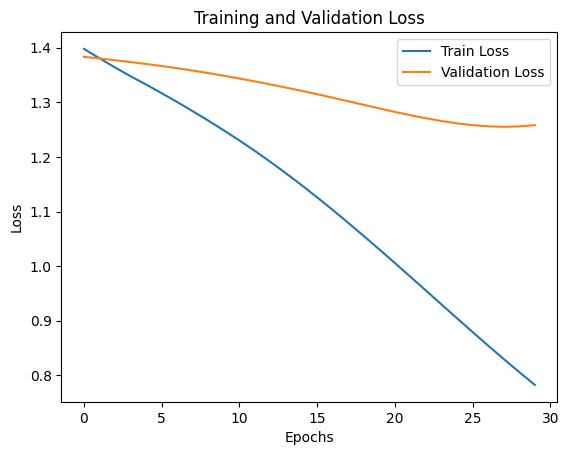

In [338]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Call Type : Moan

In [339]:
#File index
#file =  '5713.210809120002'  #from PPT at time 892-896 (Rupe B)
#file =  'Rupes A and B\\5713.210809120002'  #from PPT at time 892-896 (Rupe B)
#file = '5711.211013050024'
#file = 'Rupes A and B\\5713.210825190002'
#file =          'Moan\\5713.210902110002'  #from PPT at time 212 seconds
file = '5713.210902110002'  #from PPT at time 212 seconds

#Read the 2 files
sample_rate, samples = wavfile.read(file+'.wav')
annot_file_path = file +'.Table.1.selections.txt'

#Read the file into a DataFrame
df = pd.read_csv(file +'.Table.1.selections.txt', sep='\t')

#Display the first few rows of the DataFrame
print(df.head())

   Selection           View  Channel  Begin Time (s)  End Time (s)  \
0          1  Spectrogram 1        1      139.054770    139.162684   
1          2  Spectrogram 1        1      136.424374    136.953197   
2          3  Spectrogram 1        1      141.637244    142.016354   
3          4  Spectrogram 1        1      176.545924    176.796172   
4          5  Spectrogram 1        1      210.555520    211.194789   

   Low Freq (Hz)  High Freq (Hz)  Delta Time (s)  Delta Freq (Hz)  \
0         93.085         787.149          0.1079          694.064   
1         84.337         437.751          0.5288          353.414   
2        175.202         363.881          0.3791          188.679   
3        164.474         323.450          0.2502          158.976   
4        131.579         485.175          0.6393          353.596   

   Avg Power Density (dB FS/Hz) Annotation  
0                        -89.96   Type 4 A  
1                        -86.62     Rupe C  
2                        -89.

<ipython-input-339-5a90717584bf>:10: WavFileWarning: Reached EOF prematurely; finished at 53477376 bytes, expected 230394508 bytes from header.
  sample_rate, samples = wavfile.read(file+'.wav')


In [340]:
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nperseg=2456, nfft=4096, noverlap=1228, window='hann')       #Try nfft=8192 if computer permits

In [341]:
spectrogram[spectrogram < 0.001] = 0.001    #Trim off all the tiny values so that log scale displays correctly

#Trim in frequency
fmin = 20 # Hz
fmax = 1000 # Hz
freq_slice = np.where((frequencies >= fmin) & (frequencies <= fmax))

#keep only frequencies of interest
frequencies = frequencies[freq_slice]
spectrogram = spectrogram[freq_slice,:][0]

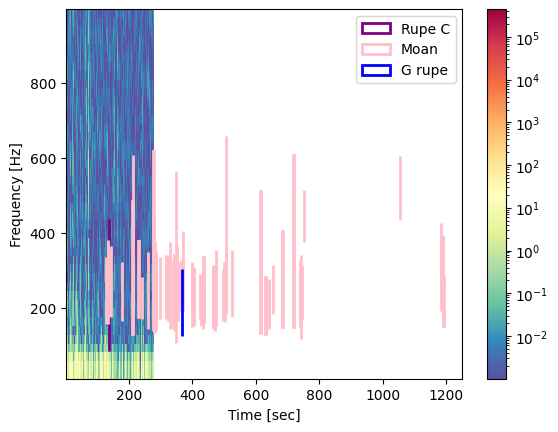

In [342]:
#Define colors for annotations
annotation_colors = {
    "Rupe A": "red",
    "Rupe B": "green",
    "Growl B": "yellow",
    "Rupe C" : "purple",
    "Moan": "pink",
    "G rupe" : "blue"
}

pc = plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
#pc = plt.pcolormesh(times, frequencies, np.log(spectrogram))
cbar = plt.colorbar(pc)
#plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

#Get the current axes
ax = plt.gca()
overlay_annotations(ax, df, annotation_colors)

#Connect the update function to the axes limit change events
ax.callbacks.connect('xlim_changed', update_colormap)
ax.callbacks.connect('ylim_changed', update_colormap)

plt.show()

(25, 469)


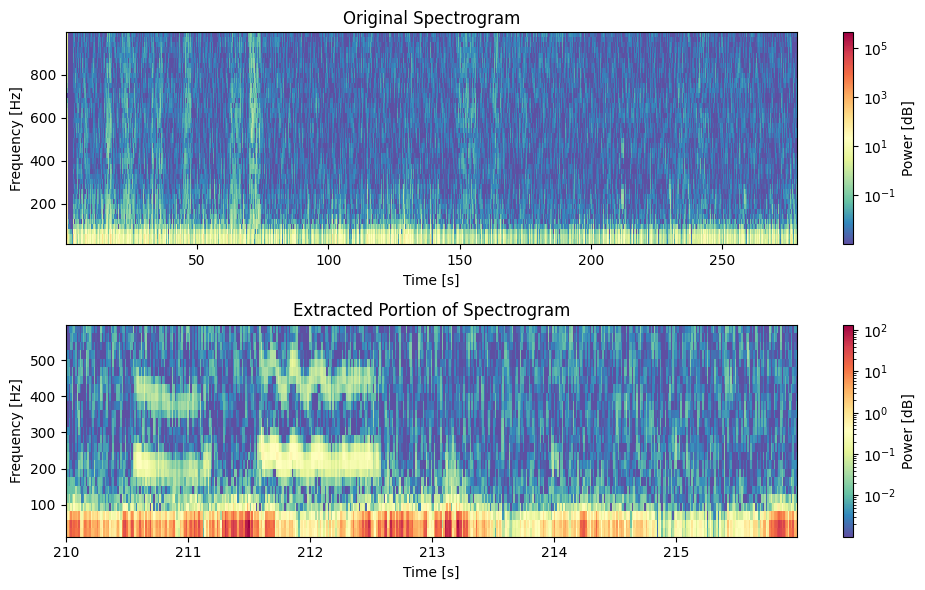

In [343]:
#Define time and frequency limits
time_start, time_end = 210, 216  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
#time_indices = np.where((times >= time_start) & (times <= time_end))[0]

# Find the closest time indices to the desired range if no exact match is found
time_indices = np.where(np.logical_and(times >= time_start, times <= time_end))[0]
if len(time_indices) == 0:
    closest_start_index = np.argmin(np.abs(times - time_start))
    closest_end_index = np.argmin(np.abs(times - time_end))
    time_indices = np.arange(closest_start_index, closest_end_index + 1)

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print(spectrogram_sub.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()


Spectrogram size:  (25, 78)


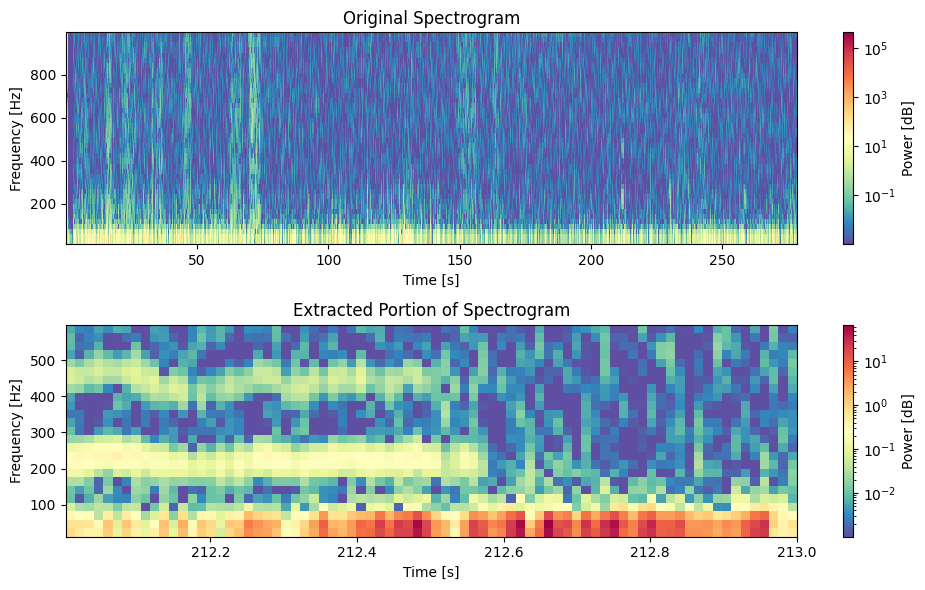

In [344]:
#Define time and frequency limits
time_start, time_end = 212.0, 213.0  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
#time_indices = np.where((times >= time_start) & (times <= time_end))[0]

# Find the closest time indices to the desired range if no exact match is found
time_indices = np.where(np.logical_and(times >= time_start, times <= time_end))[0]
if len(time_indices) == 0:
    closest_start_index = np.argmin(np.abs(times - time_start))
    closest_end_index = np.argmin(np.abs(times - time_end))
    time_indices = np.arange(closest_start_index, closest_end_index + 1)

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print("Spectrogram size: ", spectrogram_sub.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()

In [345]:
plt.savefig('spectrogram_guttaral1.png')
#plt.clf()
print(spectrogram_sub)
print(spectrogram_sub.shape)

[[8.4751338e-01 5.6599659e-01 3.9677414e-01 ... 6.0805577e-01
  4.1013125e-01 4.9556893e-01]
 [6.9149512e-01 6.8364984e-01 6.4134938e-01 ... 1.0622914e+00
  4.1615570e-01 7.0965999e-01]
 [3.3118203e-01 2.5502375e-01 2.8507507e-01 ... 9.5399731e-01
  3.4567201e-01 2.8364772e-01]
 ...
 [8.4037352e-03 2.0919575e-03 2.2450127e-03 ... 6.7407340e-03
  3.0719452e-03 2.4880802e-03]
 [8.7151937e-03 1.5017512e-03 2.7453525e-03 ... 1.2208454e-02
  1.5827398e-03 1.4344581e-03]
 [5.7351533e-03 3.0047391e-03 2.4148147e-03 ... 1.3404318e-02
  1.0000000e-03 2.7959049e-03]]
(25, 78)


<Figure size 640x480 with 0 Axes>